#### Notes

- cucim has no GPU support for aperio `.svs` files, hence neither GPU Direct Storage (GDS) nor `device=cuda` will work 

# Main

In [2]:
# run local code
import sys
import os

sys.path.append("../../src/")
from geojson2mask import geojson_to_mask

import json

# import Geojson # pip install geojson
import matplotlib.pyplot as plt
import numpy as np
import openslide
import rasterio
import rasterio.features
from rasterio import features
from shapely import geometry
import torch
import torchvision
from torchvision.utils import draw_segmentation_masks

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.cpu_count()


64

In [3]:
from glob import glob
import os

def get_case(path):
    for file in glob(path + "*.svs"):
        case = os.path.basename(file).split(".svs")[0]#.split("~")[0]
        yield case

## Read geojson and produce mask

In [4]:
#base_path: str = "/data2/projects/DigiStrudMed_sklein/sample-case/Scans-QuPathProjekt-RCC(1Case)-10062021/"
# base_path: str = "/media/sciobiome/DATA/sklein_tmp/Scans-QuPathProjekt-RCC-1Case-10062021/"
base_path:str = "/data2/projects/DigiStrudMed_sklein/sample-case/Scans-fuer-QupathProjekt-RCC-3Faelle-10062021/"

# Define example
case: str = "RCC-TA-011.001.023~M" # 1.8 gb
#case: str = "RCC-TA-070.019~E" # 27 gb
#case: str = "RCC-TA-070.016~H" # 3.5 gb
image = base_path + case + ".svs"
images = {case: image}

# all images
#images = {case: base_path + case + ".svs" for case in get_case(base_path)}


# JSON array like this [{type: ..., id: ..., geometry: ..., properties: ...}, {...}, ...]
geojson_array: str = base_path + case + ".svs.json"

annos_of_interest: list[str] = [
    "Tumor_vital",
    "diffuse tumor growth in soft tissue",
    "Angioinvasion",
    "Tumor_necrosis",
    "Tumor_regression",
    "Tissue",
]


In [5]:
svs = openslide.open_slide(image)
width, height = svs.dimensions

masks = {}

for case, path in images.items():
    # if case == "Image":
    svs = openslide.open_slide(path)
    width, height = svs.dimensions
    masks[case] = geojson_to_mask(path+".json", annos_of_interest, (height, width))


TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFRe

In [9]:
masks['RCC-TA-011.001.023~M']['Tissue'].shape

(98661, 100105)

In [6]:
import sys

for case in masks.keys():
    print(masks[case].keys())
    for item in masks[case].values():
        print(item.dtype)
        print(item.shape)
        print(item.size * item.itemsize // 1024**2)

dict_keys(['Tumor_regression', 'Tissue', 'Tumor_vital'])
uint8
(98661, 100105)
9418
uint8
(98661, 100105)
9418
uint8
(98661, 100105)
9418


## Transforms

In [7]:
from monai.data import WSIReader
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    CropForegroundd,
    MaskIntensityd,
    ScaleIntensityd,
    Resize,
    ToTensord,
    Lambdad,
    LoadImage,
    EnsureTyped,
    MapTransform,
    Transform,
    ResizeWithPadOrCropd,
    GridPatchd,
    AddChanneld,
)


In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.


In [8]:
images

{'RCC-TA-011.001.023~M': '/data2/projects/DigiStrudMed_sklein/sample-case/Scans-fuer-QupathProjekt-RCC-3Faelle-10062021/RCC-TA-011.001.023~M.svs'}

In [9]:
masks

{'RCC-TA-011.001.023~M': {'Tumor_regression': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'Tissue': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'Tumor_vital': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}}

In [10]:
patch_size = (512, 512)
tissue_mask = {}
other_masks = {}

input_data=[]
for idx, (case, path) in enumerate(images.items()):
    input_data.append({"Image": path, "ID": case})
    for anno_type, mask in masks[case].items():
        input_data[idx].update({anno_type: mask})

input_data = [{
    "Image": path,
    "ID": case,
    "Tumor_vital": masks[case]["Tumor_vital"],
    #"diffuse tumor growth in soft tissue": masks[case]["diffuse tumor growth in soft tissue"],
    #"Angioinvasion": masks[case]["Angioinvasion"],
    #"Tumor_necrosis": masks[case]["Tumor_necrosis"],
    "Tumor_regression": masks[case]["Tumor_regression"],
    "Tissue": masks[case]["Tissue"],
} for case, path in images.items()]


input_data[0]#["ID"]

{'Image': '/data2/projects/DigiStrudMed_sklein/sample-case/Scans-fuer-QupathProjekt-RCC-3Faelle-10062021/RCC-TA-011.001.023~M.svs',
 'ID': 'RCC-TA-011.001.023~M',
 'Tumor_vital': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'Tumor_regression': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'Tissue': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [11]:
# from cucim import CuImage

# # Get the repective max dimensions of the images
# img_dims = []
# for temp_case in input_data:
#     print(temp_case)
# # Get the repective max dimensions of the images
# img_dims = []
# for temp_case in input_data:
#     print(temp_case)
#     img, *other = temp_case.values()
#     img_dims.append(CuImage(img).shape[:2])
#     # img_dims.append(LoadImage(image_only=True)(img).shape[-2:])
#     xmax, ymax = np.max(img_dims, axis=0)

# try:
#     # find first value bigger than max and divisible by 512
#     xtarg = patch_size[0] * (xmax // patch_size[0] + 1)
#     ytarg = patch_size[1] * (ymax // patch_size[1] + 1)
# except Exception as e:
#     print(e)
#     print("assignment of xmax, ymax failed")

#     img, *other = temp_case.values()
#     img_dims.append(CuImage(img).shape[:2])
#     # img_dims.append(LoadImage(image_only=True)(img).shape[-2:])
#     xmax, ymax = np.max(img_dims, axis=0)

# try:
#     # find first value bigger than max and divisible by 512
#     xtarg = patch_size[0] * (xmax // patch_size[0] + 1)
#     ytarg = patch_size[1] * (ymax // patch_size[1] + 1)
# except Exception as e:
#     print(e)
#     print("assignment of xmax, ymax failed")


In [12]:
# monai MapTransform that loads torch tensors analogous to SaveTensorsd
from typing import Hashable, Mapping, Type
from monai.config import IndexSelection, KeysCollection, SequenceStr
import monai

class LoadTensorsd(MapTransform):
    def __init__(self, keys: KeysCollection, output_dir: str, dtype: Type=None, device:torch.device = torch.device("cpu"), allow_missing_keys: bool = False, prefix: str = "") -> None:
        super().__init__(keys, allow_missing_keys)
        self.dtype: Type = dtype
        self.output_dir: str = output_dir
        self.device = device
        self.prefix: str = prefix

    def __call__(self, data: Mapping[Hashable, torch.Tensor]) -> dict[Hashable, torch.Tensor]:
        d: dict[Hashable, torch.Tensor] = dict(data)
        for key in self.key_iterator(d):
            d[key] = torch.load(os.path.join(self.output_dir, f"{self.prefix}-{data['ID']}-{str(key)}-.pt"), map_location=self.device).astype(self.dtype)
            d[key] = d[key].type(self.dtype) if self.dtype else d[key]
        return d

In [13]:
# monai MapTranform that saves the tensors via torch.save to disk
class SaveTensorsd(MapTransform):
    def __init__(self, keys: KeysCollection, output_dir:str, allow_missing_keys: bool = False, prefix: str = "") -> None:
        super().__init__(keys, allow_missing_keys)
        self.output_dir: str = output_dir
        self.prefix: str = prefix

    def __call__(self, data)-> dict:
        d: dict[Hashable, torch.Tensor] = dict(data)
        for key in self.key_iterator(d):
            # torch.save(data[key], os.path.join(self.output_dir, f"{os.path.splitext(os.path.basename(data['Image']))[0]}-{str(key)}-.pt"))
            torch.save(data[key], os.path.join(self.output_dir, f"{self.prefix}-{data['ID']}-{str(key)}-.pt"), pickle_protocol=5)

        return d

In [14]:
# monai MaptTransform that saves the max shape of the data on the keys
from typing import Sequence, Tuple, Union


class SaveMaxShaped(MapTransform):
    def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False,):
        super().__init__(keys, allow_missing_keys)
        self.max_width: int = 0
        self.max_height: int = 0

    def __call__(self, data):
        for key in self.keys:
            height, width = data[key].shape[-2:]
            self.max_height = max(self.max_height, height)
            self.max_width = max(self.max_width, width)

        return data

In [15]:
# masks[case] = geojson_to_mask(path+".json", annos_of_interest, (height, width))


In [16]:
# need to have a reference to this. Could also use Lambdad as a simpler approach perhaps
image_max_shape = SaveMaxShaped(keys=["Image"])

crop_transform = Compose(
    [
        LoadImaged(
            keys=[
                "Image",
            ],
            reader=WSIReader,
            level=0,
            backend="cucim",
            num_workers=os.cpu_count(),
            ensure_channel_first=True,
        ),
        # ToTensord(
        #     allow_missing_keys=True,
        #     keys=annos_of_interest+["Image"]
        # ),
        EnsureChannelFirstd(
            keys=annos_of_interest,
            channel_dim="no_channel",
            allow_missing_keys=True
        ),
        # select pixels with value > 0 from "Tissue" as foreground (default function)
        CropForegroundd(keys=annos_of_interest+["Image"], source_key="Tissue", allow_missing_keys=True,),
        image_max_shape,
        SaveTensorsd(keys=annos_of_interest+["Image"], output_dir=base_path, prefix="Cropped", allow_missing_keys=True,),
    ]
)


In [17]:
patch_transform = Compose(
    [
        LoadTensorsd(keys=annos_of_interest, output_dir=base_path, allow_missing_keys=True, prefix="Cropped"),
        
        ResizeWithPadOrCropd(
            allow_missing_keys=True,
            keys=annos_of_interest+["Image"],
            spatial_size=(image_max_shape.max_height, image_max_shape.max_width),
            mode="constant",
            value=0,
        ),
        GridPatchd(
            keys=annos_of_interest+["Image"], allow_missing_keys=True, patch_size=patch_size
        ),
        SaveTensorsd(keys=annos_of_interest+["Image"], output_dir=base_path, prefix="Patch"),
    ]
)


In [18]:
input_data

[{'Image': '/data2/projects/DigiStrudMed_sklein/sample-case/Scans-fuer-QupathProjekt-RCC-3Faelle-10062021/RCC-TA-011.001.023~M.svs',
  'ID': 'RCC-TA-011.001.023~M',
  'Tumor_vital': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'Tumor_regression': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'Tissue': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}]

In [19]:
cropped = crop_transform(input_data)

TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.


In [20]:
cropped[0].keys()

dict_keys(['Image', 'ID', 'Tumor_vital', 'Tumor_regression', 'Tissue', 'Image_meta_dict', 'foreground_start_coord', 'foreground_end_coord'])

In [25]:
cropped[0]["Image"].shape

torch.Size([3, 23228, 26308])

In [26]:
cropped[0]["Image_meta_dict"]

{'backend': 'cucim',
 'original_channel_dim': 0,
 'spatial_shape': array([ 98661, 100105]),
 'count': 1,
 'path': '/data2/projects/DigiStrudMed_sklein/sample-case/Scans-fuer-QupathProjekt-RCC-3Faelle-10062021/RCC-TA-011.001.023~M.svs',
 'location': array([0, 0]),
 'size': array([ 98661, 100105]),
 'level': 0,
 'filename_or_obj': '/data2/projects/DigiStrudMed_sklein/sample-case/Scans-fuer-QupathProjekt-RCC-3Faelle-10062021/RCC-TA-011.001.023~M.svs',
 affine: tensor([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]], dtype=torch.float64),
 space: RAS}

In [ ]:
patched = patch_transform(cropped)

In [ ]:
iamge_transform = Compose(
    # scale intensity
    # make background from mask white in image
    # MaskIntensityd(keys=["Image"], mask_key="Tissue", ...),
    MaskIntensityd(keys=["Image"], mask_key="Tissue", allow_missing_keys=True),



)

In [61]:
# wsi_transforms = Compose(
#     [
#         LoadImaged(
#             keys=[
#                 "image",
#             ],
#             reader=WSIReader,
#             level=0,
#             backend="cucim",
#             num_workers=os.cpu_count(),
#         ),
#         ToTensord(
#             keys=["image", "Tissue", "other"]
#         ),  # , device=device),  # should be the last transform
#         EnsureChannelFirstd(
#             keys=[
#                 "image",
#             ]
#         ),
#         EnsureChannelFirstd(
#             keys=[
#                 "Tissue",
#             ],
#             channel_dim="no_channel",
#         ),
#         # select pixels with value > 0 from "Tissue" as foreground (default function)
#         CropForegroundd(keys=["image", "Tissue", "other"], source_key="Tissue"),
#         # replace background with black from mask image
#         MaskIntensityd(
#             keys=["image", "Tissue", "other"],
#             select_fn=lambda x: x != 0,
#             mask_key="Tissue",
#         ),
#         # Resize to the maximum size of the image and mask
#         # Resized(keys=["image", "Tissue"], spatial_size=(xmax, ymax), mode="area"),
#         ResizeWithPadOrCropd(
#             keys=["image", "Tissue", "other"],
#             spatial_size=(xtarg, ytarg),
#             mode="constant",
#             value=0,
#         ),
#         GridPatchd(keys=["image", "Tissue", "other"], patch_size=patch_size),
#         # # Scales intensity to [0, 1] (default function)
#         # ScaleIntensityd(keys=["img", "seg"]),
#         # ScaleIntensityRangeD(keys=["image"], a_min=np.float32(255), a_max=np.float32(0)),
#         # ToDevice(keys=["image", "Tissue"], device=device), # TODO: check this for the biggest image
#         # transforms.CuCIM() # <-- this could be useful for image registration
#     ]
# )

# post_transform_data = wsi_transforms(input_data)
# #post_resize_data = wsi_transforms(input_data)


NameError: name 'xtarg' is not defined

In [ ]:
for sub_case in post_transform_data:
    print(sub_case["image"].shappräprozessierunge)
    print(sub_case["Tissue"].shape)
    print(sub_case["other"].shape)
    print(sub_case["case"])


torch.Size([37828, 3, 512, 512])
torch.Size([37828, 1, 512, 512])
torch.Size([37828, 2, 512, 512])
RCC-TA-011.001.023~M


In [ ]:
torch.cat(
    (
        post_transform_data[0]["image"],
        post_transform_data[0]["Tissue"],
        post_transform_data[0]["other"],
    ),
    dim=1,
).shape


torch.Size([37828, 6, 512, 512])

## TODO

Steps to fix this shit:
1. Render full size tiffs as masks
2. render low res pngs as masks (16x?)
3. modify PatchMaskWSI:
    - take low-res as input to calculate location
    - extract patches according to location from each svs and tiff image
    - concat patches
    - apply transform
    - ???
    - Profit

In [ ]:
post_transform_data[0]["image_meta_dict"]


{'backend': 'cucim',
 'original_channel_dim': 0,
 'spatial_shape': array([ 98661, 100105]),
 'count': 1,
 'path': '/data2/projects/DigiStrudMed_sklein/sample-case/Scans-QuPathProjekt-RCC(1Case)-10062021/RCC-TA-011.001.023~M.svs',
 'location': array([0, 0]),
 'size': array([ 98661, 100105]),
 'level': 0,
 'filename_or_obj': '/data2/projects/DigiStrudMed_sklein/sample-case/Scans-QuPathProjekt-RCC(1Case)-10062021/RCC-TA-011.001.023~M.svs',
 affine: tensor([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]], dtype=torch.float64),
 space: RAS}

## Plotting

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(
            np.asarray(img), interpolation="none", cmap="gray", vmin=0, vmax=1
        )
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


torch.Size([1, 98661, 100105])


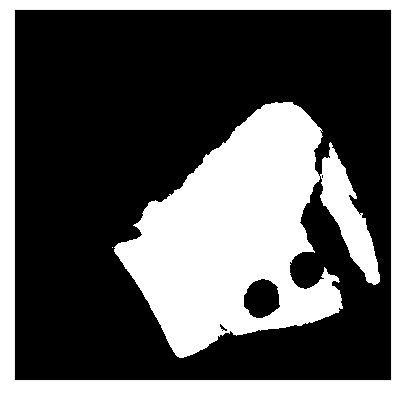

In [ ]:
print(label.shape)
show(label)


torch.Size([3, 98661, 100105])


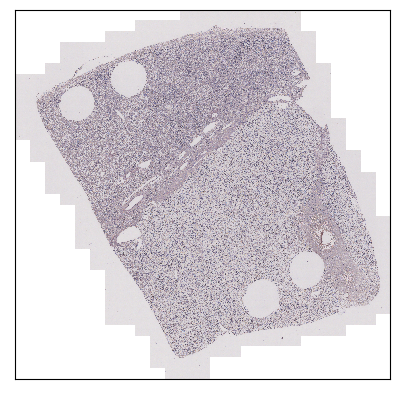

In [ ]:
print(image_data.shape)
show(image_data)


In [ ]:
torch_segmentated_image = torchvision.utils.draw_segmentation_masks(
    image_data, label.eq(1), alpha=0.3, colors="green"
)
torch_segmentated_image = torch_segmentated_image.to(device=device)


OutOfMemoryError: CUDA out of memory. Tried to allocate 9.20 GiB (GPU 0; 44.43 GiB total capacity; 36.79 GiB already allocated; 6.92 GiB free; 36.79 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
print(torch_segmentated_image.shape)
show(torch_segmentated_image)

torch_segmentated_image


In [ ]:
monai_blended_image = monai.visualize.utils.blend_images(
    torch.einsum(
        "cwh -> chw", image_data
    ),  # move channel first and match dimensinos woth label
    label,
    alpha=0.5,
    cmap="hsv",
    rescale_arrays=True,
    transparent_background=True,
)


### Plot overlay of mask on image

### Plot masks alone

In [ ]:
case_all_masks = [
    torch.from_numpy(
        mask
    )  # torchvision.utils.draw_segmentation_masks(img, masks=mask, alpha=.6)
    for img, mask in masks[case].items()
]
show(case_all_masks)


In [ ]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(30,30)) # specifying the overall grid size

# for idx, (name, mask) in zip(range(5), masks[case].items()):
#     # print(name)
#     #print(mask[name])
#     plt.subplot(3,3,idx+1)
#     plt.imshow(mask[name])

# plt.show()

fig, axes = plt.subplots(nrows=1, ncols=len(masks[case]))  # ,figsize=(10,30)
# axes = axes.ravel()

# for idx, (name, mask) in enumerate(masks[case].items()):
#     axes[idx].imshow(mask)
#     axes[idx].set_title(name)
#     axes[idx].axis('off')

fig.suptitle(case, va="bottom")
fig.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
for idx, (name, mask) in enumerate(masks[case].items()):
    sns.heatmap(
        mask, cmap="gray", ax=ax[idx], cbar=False, xticklabels=False, yticklabels=False
    )
    axes[idx].set_title(name)

plt.suptitle(case, x=0.5, y=1, fontsize=20)
plt.show()


In [25]:
from torch import Tensor
from typing import Union
import __future__

import os
import sys
from glob import glob

# compat
sys.path.append("../src/")

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from sksurv.linear_model import CoxPHSurvivalAnalysis
from torch.utils.data import DataLoader, Dataset, random_split

from cucim import CuImage

# command `tensorboard --logdir=path/to/logs` to start TensorBoard server, then open http://localhost:6006 to access dashboard.
from torch.utils.tensorboard import SummaryWriter

from MaskDataset import PatchMaskDataset
from PyvipsWrapper import numpy2pyramid
from geojson2mask import geojson_to_mask

In [23]:
input_dir: str = "/data2/projects/DigiStrudMed_sklein/sample-case/Scans-fuer-QupathProjekt-RCC-3Faelle-10062021/"
output_dir: str = ""

annos_of_interest: list[str] = [
    "Tissue",
    "Tumor_vital",
    "diffuse_tumor_growth_in_soft_tissue",
    "Angioinvasion",
    "Tumor_necrosis",
    "Tumor_regression",
]

images: list[str] = sorted(glob(os.path.join(input_dir, "*.svs")))
geojsons: list[str] = sorted(glob(os.path.join(input_dir, "*.json")))

masks: dict = {}
for annnotation in annos_of_interest:
    masks[annnotation.removesuffix(".tif")] = sorted(
        glob(os.path.join(input_dir, f"*{annnotation}*.tif"))
    )

input_dicts: list[dict[str, str]] = [dict(zip(masks, t)) for t in zip(*masks.values())]

# TODO
# csv: list[str] = sorted(glob(os.path.join(input_dir, "*.csv")))


In [24]:
# convert from dict of lists to list of dicts
tmp = []
for key, values in masks.items():
    for idx, value in enumerate(values):
        try:
            tmp[idx] |= {key: value}
        except:
            tmp.append({key: value})
input_dicts = tmp


In [27]:
import pyvips


In [28]:
img = pyvips.Image.tiffload(masks["Tissue"][0])


In [29]:
img = pyvips.Image.new_from_file(masks["Tissue"][0])


img = img.crop(1234, 2314, 3000, 3000)
import torch


In [32]:
len(img)

TypeError: object of type 'Image' has no len()

In [30]:
torch.asarray(img)


TypeError: object of type 'Image' has no len()